# Demand Forecasting Model

In [ ]:
import numpy as np
import pandas as pd
import holidays
from prophet import Prophet # pip install prophet and plotly 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from joblib import Parallel, delayed
import os
import sys 
import contextlib

## Dataset

In [32]:
orders = pd.read_csv('data/dataprep_purchases.csv')

orders

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Survey ResponseID,Category
0,2018-12-04,7.98,1,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,R_01vNIayewjIIKMF,Electronics
1,2018-12-22,13.99,1,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,R_01vNIayewjIIKMF,Electronics
2,2018-12-24,8.99,1,NJ,NaN,B078JZTFN3,R_01vNIayewjIIKMF,NaN
3,2018-12-25,10.45,1,NJ,Perfecto Stainless Steel Shaving Bowl. Durable...,B06XWF9HML,R_01vNIayewjIIKMF,Kitchen & Dining
4,2018-12-25,10.00,1,NJ,Proraso Shaving Cream for Men,B00837ZOI0,R_01vNIayewjIIKMF,Beauty & Personal Care
...,...,...,...,...,...,...,...,...
1530758,2019-06-07,16.80,1,MA,Cosrx Galactomyces 95 Tone Balancing Essence 1...,B00OZE57XW,R_zfqnsBzlOAKibzb,Beauty & Personal Care
1530759,2019-08-14,7.97,1,MA,Coppertone Limited Edition ULTRA GUARD SPF 70 ...,B001TKOHMM,R_zfqnsBzlOAKibzb,Beauty & Personal Care
1530760,2019-09-30,6.68,1,MA,Greeks and Their Gods,0807057932,R_zfqnsBzlOAKibzb,Books
1530761,2019-10-13,16.90,1,MA,"MIZON Snail Repair Cream, Face Moisturizer wit...",B00AF63QQE,R_zfqnsBzlOAKibzb,Beauty & Personal Care


## Data Cleaning and Preprocessing

In [33]:
# Drop unnecessary columns
orders = orders.drop(['Survey ResponseID'], axis=1)

# Remove null values
orders.isnull().sum()
orders = orders.dropna()

orders

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category
0,2018-12-04,7.98,1,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,Electronics
1,2018-12-22,13.99,1,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,Electronics
3,2018-12-25,10.45,1,NJ,Perfecto Stainless Steel Shaving Bowl. Durable...,B06XWF9HML,Kitchen & Dining
4,2018-12-25,10.00,1,NJ,Proraso Shaving Cream for Men,B00837ZOI0,Beauty & Personal Care
5,2019-02-18,10.99,1,NJ,Micro USB Cable Android Charger - Syncwire [2-...,B01GFB2E9M,Computer & Accessories
...,...,...,...,...,...,...,...
1530758,2019-06-07,16.80,1,MA,Cosrx Galactomyces 95 Tone Balancing Essence 1...,B00OZE57XW,Beauty & Personal Care
1530759,2019-08-14,7.97,1,MA,Coppertone Limited Edition ULTRA GUARD SPF 70 ...,B001TKOHMM,Beauty & Personal Care
1530760,2019-09-30,6.68,1,MA,Greeks and Their Gods,0807057932,Books
1530761,2019-10-13,16.90,1,MA,"MIZON Snail Repair Cream, Face Moisturizer wit...",B00AF63QQE,Beauty & Personal Care


Product

In [54]:
# Sort by `Order Date`
orders = orders.sort_values('Order Date')

# Parse 'Order Date' and add 'Year-Month' period
orders['Order Date'] = pd.to_datetime(orders['Order Date'])
orders['Year-Month'] = orders['Order Date'].dt.to_period('M')
orders['Year'] = orders['Order Date'].dt.year
orders['Month'] = orders['Order Date'].dt.month
orders['Quarter'] = orders['Order Date'].dt.to_period('Q')

# Group states by geographic region under a new column `Region`
def regions(state):
    if state in ['NY', 'NJ', 'PA', 'MA', 'CT', 'RI', 'NH', 'VT', 'ME', 'MD', 'DE']:
        return 'Northeast'
    elif state in ['WA', 'OR', 'CA', 'NV', 'UT', 'ID', 'MT', 'WY', 'CO', 'AK', 'HI']:
        return 'West'
    elif state in ['IL', 'OH', 'MI', 'IN', 'WI', 'MN', 'IA', 'MO', 'ND', 'SD', 'NE', 'KS']:
        return 'Midwest'
    elif state in ['TX', 'OK', 'NM', 'AZ']:
        return 'Southwest'
    else:  
        return 'Southeast'
orders['Region'] = orders['Shipping Address State'].apply(regions)

orders

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Year-Month,Year,Quarter,Region,Month
669887,2018-01-01,18.46,1,NY,Yaktrax Hiking and Walking Traction Cleats for...,B001CZJIPA,Sports and Outdoors,2018-01,2018,2018Q1,Northeast,1
1205052,2018-01-01,10.99,1,UT,Fintie Slim Shell Case for Samsung Galaxy Tab ...,B00JGHPKWQ,Electronics,2018-01,2018,2018Q1,West,1
1409624,2018-01-01,2.94,1,IN,"Alba Botanica Hawaiian Detox Towelettes, Anti-...",B01HPWEZT2,Beauty & Personal Care,2018-01,2018,2018Q1,Midwest,1
915311,2018-01-01,5.39,1,WA,Electop 3.5mm 1/8 inch Male AUX Audio Plug Jac...,B01FEXD3X8,Electronics,2018-01,2018,2018Q1,West,1
554922,2018-01-01,8.09,1,AL,The Lies of Locke Lamora (Gentleman Bastards),055358894X,Books,2018-01,2018,2018Q1,Southeast,1
...,...,...,...,...,...,...,...,...,...,...,...,...
290101,2022-10-31,21.98,1,VA,"Donut Stop Flavored Coffee Pods, Compatible wi...",B0842QPVZM,Grocery,2022-10,2022,2022Q4,Southeast,10
840121,2022-10-31,41.78,1,OH,Alpine Corporation TEC106-BZ Alpine Floor Foun...,B00W5TIZ0G,Garden & Outdoor,2022-10,2022,2022Q4,Midwest,10
840120,2022-10-31,6.99,1,OH,"Christmas Decorations, INNENS 8 Sheets Christm...",B0BBZ52VZ3,Home,2022-10,2022,2022Q4,Midwest,10
334681,2022-10-31,9.95,1,WI,Holikme Door Draft Stopper Under Door Draft Bl...,B07MSM6G9R,Home,2022-10,2022,2022Q4,Midwest,10


## Visualisation 1: Relationship between Sales and Quarters  

In [55]:
# Omitting 2022 data for the visualisation as data is incomplete
orders_omit = orders[orders['Year'] < 2022]

orders_omit

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Year-Month,Year,Quarter,Region,Month
669887,2018-01-01,18.46,1,NY,Yaktrax Hiking and Walking Traction Cleats for...,B001CZJIPA,Sports and Outdoors,2018-01,2018,2018Q1,Northeast,1
1205052,2018-01-01,10.99,1,UT,Fintie Slim Shell Case for Samsung Galaxy Tab ...,B00JGHPKWQ,Electronics,2018-01,2018,2018Q1,West,1
1409624,2018-01-01,2.94,1,IN,"Alba Botanica Hawaiian Detox Towelettes, Anti-...",B01HPWEZT2,Beauty & Personal Care,2018-01,2018,2018Q1,Midwest,1
915311,2018-01-01,5.39,1,WA,Electop 3.5mm 1/8 inch Male AUX Audio Plug Jac...,B01FEXD3X8,Electronics,2018-01,2018,2018Q1,West,1
554922,2018-01-01,8.09,1,AL,The Lies of Locke Lamora (Gentleman Bastards),055358894X,Books,2018-01,2018,2018Q1,Southeast,1
...,...,...,...,...,...,...,...,...,...,...,...,...
300519,2021-12-31,13.99,1,PA,"Quaker Chewy Granola Bars, Chewy & Dipps Varie...",B01LNKHDAK,Grocery,2021-12,2021,2021Q4,Northeast,12
970061,2021-12-31,14.99,1,LA,UTest -O-Meter 5 Level THC Home Drug Test | Ma...,B01N1Z975Y,"Health, Household & Personal Care",2021-12,2021,2021Q4,Southeast,12
816378,2021-12-31,15.99,2,CA,"TP-Link N300 WiFi Extender(RE105), WiFi Extend...",B08DHLCLCY,Electronics,2021-12,2021,2021Q4,West,12
45346,2021-12-31,15.99,1,GA,Bedecor Mattress Sheets for Air Bed Cover Remo...,B093PXNP2G,Home,2021-12,2021,2021Q4,Southeast,12


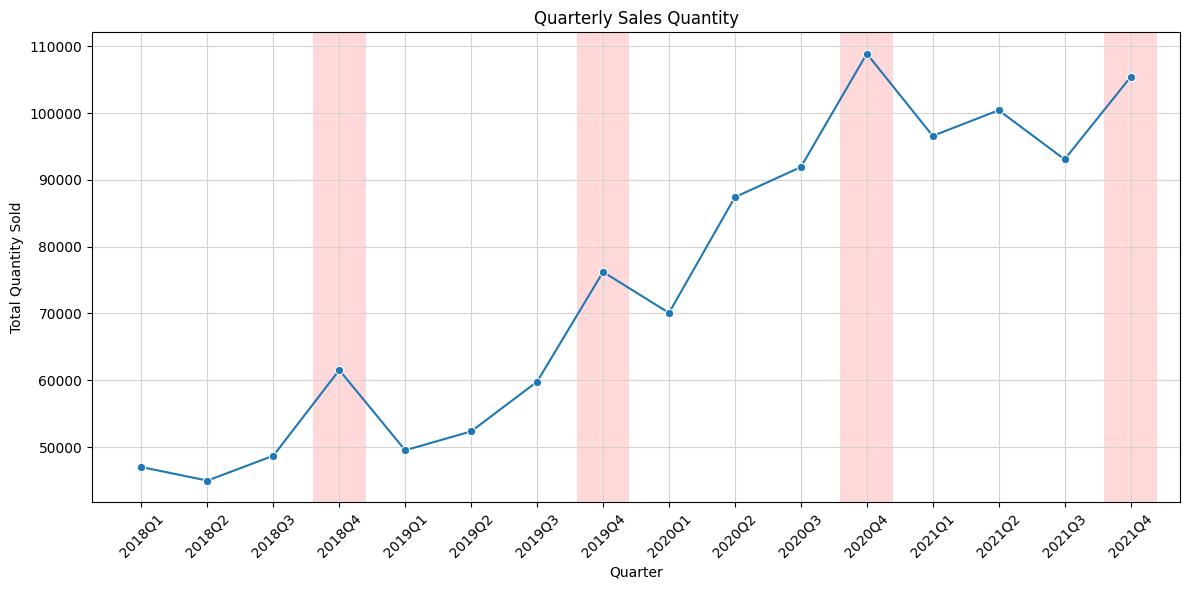

In [36]:
# Aggregate sales volume quarterly
quarterly_data = orders_omit.groupby('Quarter').agg({
    'Quantity': 'sum',
    'Purchase Price Per Unit': 'mean'
}).reset_index()

# Calculate number of holidays per quarter
us_holidays = holidays.US(years=range(orders_omit['Year'].min(), orders_omit['Year'].max() + 1))
holiday_counts = {}

for date, name in us_holidays.items():
    quarter = pd.Period(date, freq='Q')
    holiday_counts[quarter] = holiday_counts.get(quarter, 0) + 1

# Convert holiday counts to a DataFrame for easier merging
holiday_counts_df = pd.DataFrame(holiday_counts.items(), columns=['Quarter', 'Holiday Count'])

# Merge with the quarterly_data to add holiday counts
quarterly_data = pd.merge(quarterly_data, holiday_counts_df, on='Quarter', how='left').fillna(0)

# Identify the top quarters with the most holidays
top_holiday_quarters = quarterly_data[quarterly_data['Holiday Count'] >= 4]

# Plotting the data
plt.figure(figsize=(12, 6))
sns.lineplot(x=quarterly_data['Quarter'].astype(str), y=quarterly_data['Quantity'], marker='o')

# Highlight top quarters with a vertical box
ax = plt.gca()
for _, row in top_holiday_quarters.iterrows():
    quarter_index = quarterly_data[quarterly_data['Quarter'] == row['Quarter']].index[0]
    quantity_max = quarterly_data['Quantity'].max() + 4000  # Get maximum quantity for height

    ax.add_patch(
        patches.Rectangle(
            (quarter_index - 0.4, 0), 
            0.8,  # Width of the box
            quantity_max,  # Height of the box
            edgecolor='none',
            facecolor='red',
            alpha = 0.15,
            lw=2
        )
    )

plt.title("Quarterly Sales Quantity")
plt.xlabel("Quarter")
plt.ylabel("Total Quantity Sold")
plt.xticks(rotation=45)
plt.tight_layout()

plt.grid(True, color='lightgray')

plt.show()

## Visualisation 2: Relationship between Sales and Region  

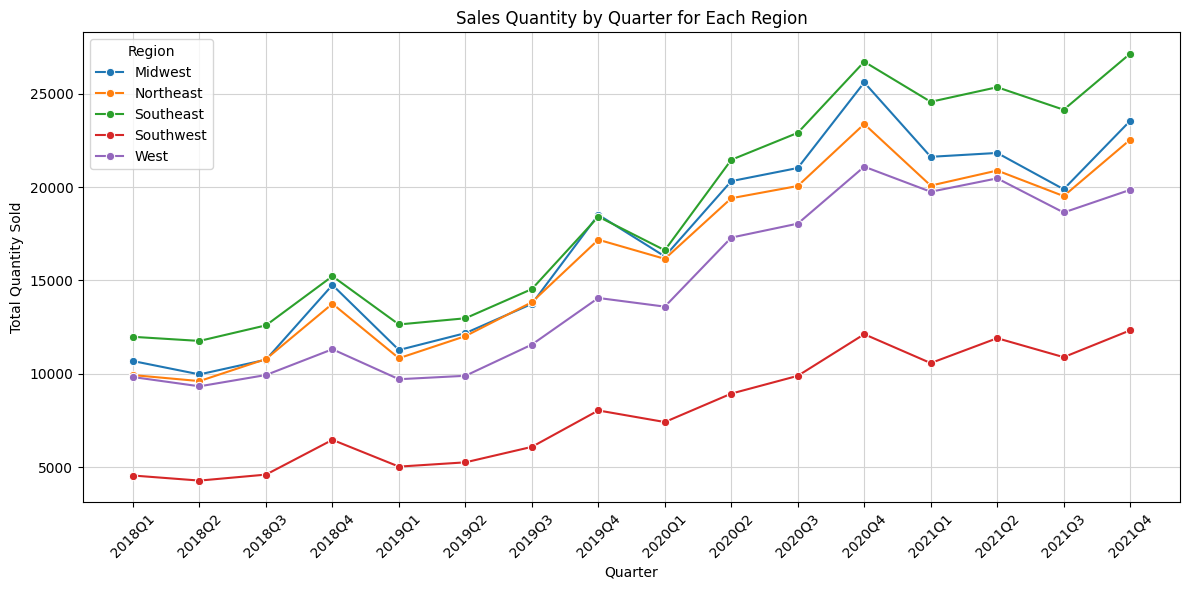

In [37]:
# Aggregate sales quantity by quarter and region
region_data = orders_omit.groupby(['Quarter', 'Region'])['Quantity'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=region_data, x=region_data['Quarter'].astype(str), y=region_data['Quantity'], hue=region_data['Region'], marker='o', palette="tab10")

# Adding plot details
plt.title("Sales Quantity by Quarter for Each Region")
plt.xlabel("Quarter")
plt.ylabel("Total Quantity Sold")
plt.xticks(rotation=45)
plt.legend(title="Region")
plt.tight_layout()

plt.grid(True, color='lightgray')

plt.show()

## Visualisation 3: Relationship between Sales and Top 5 Category  

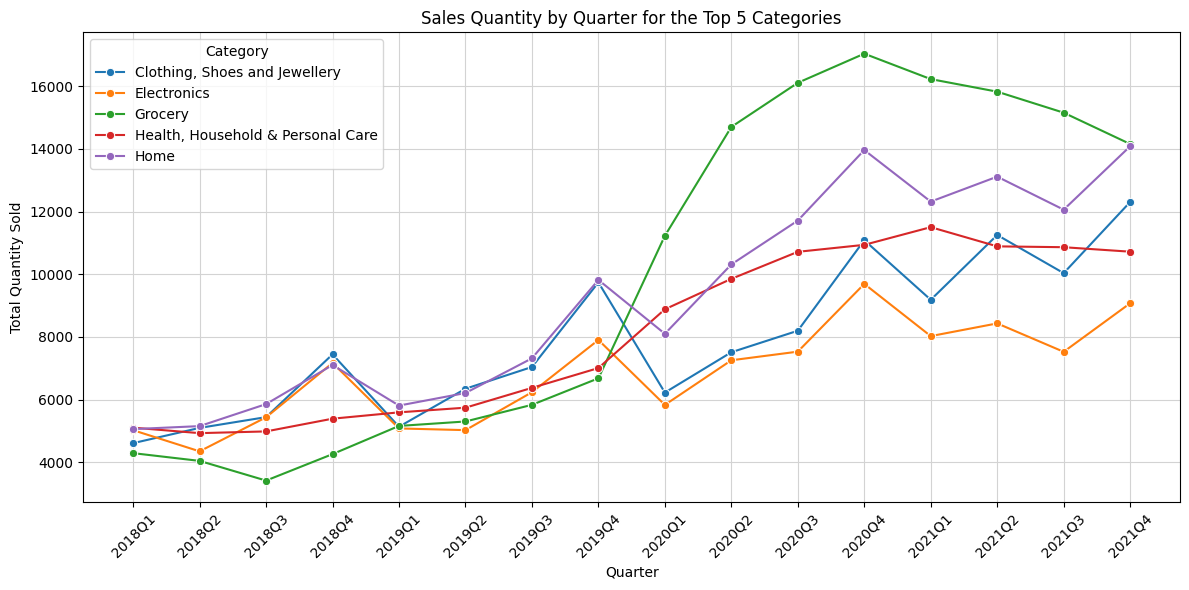

In [38]:
# Filter for top 5 categories
top_categories = (
    orders_omit.groupby('Category')['Quantity']
    .sum()
    .nlargest(5)
    .index
)

# Filter daily_data to keep only the top 5 categories
orders_category = orders_omit[orders_omit['Category'].isin(top_categories)]

# Aggregate sales quantity by quarter and category
category_data = orders_category.groupby(['Quarter', 'Category'])['Quantity'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=category_data, x=category_data['Quarter'].astype(str), y=category_data['Quantity'], hue=category_data['Category'], marker='o', palette="tab10")

# Adding plot details
plt.title("Sales Quantity by Quarter for the Top 5 Categories")
plt.xlabel("Quarter")
plt.ylabel("Total Quantity Sold")
plt.xticks(rotation=45)
plt.legend(title="Category")
plt.tight_layout()

plt.grid(True, color='lightgray')

plt.show()

## Prophet Model  
Predicts total sales per month and region for each product.

Prepare dataset for model  
1. Aggregate data by month, product, region and category to get total sales 
2. Create the `ds` and `y` columns for Prophet compatibility

In [56]:
monthly_data = orders.groupby(['Year-Month', 'Title', 'ASIN/ISBN (Product Code)', 'Region', 'Category']).agg({'Quantity': 'sum'}).reset_index()

# Create `ds` column, setting the day to the first of each month
monthly_data['ds'] = monthly_data['Year-Month'].dt.to_timestamp()

# Rename columns for Prophet compatibility
monthly_data = monthly_data.rename(columns={'Quantity': 'y'})

monthly_data

,Year-Month,Title,ASIN/ISBN (Product Code),Region,Category,y,ds
0,2018-01,"""Inkopolis Badge set"" Deluxe Metal Pins",B01D0K21ZS,Southeast,"Clothing, Shoes and Jewellery",1,2018-01-01
1,2018-01,"""SlipToGrip"" 4 Pack Furniture Grippers by iPri...",B017HO23QU,Southeast,Home,1,2018-01-01
2,2018-01,#10 Security Tinted Self-Seal Envelopes - No W...,B01D0OANU4,Southeast,Office Products,1,2018-01-01
3,2018-01,#10 Security Tinted Self-Seal Envelopes - No W...,B01D0OANU4,Southwest,Office Products,3,2018-01-01
4,2018-01,"#LubeLife Anal Silicone-Based Lubricant, Water...",B075SMY97R,Southwest,"Health, Household & Personal Care",1,2018-01-01
...,...,...,...,...,...,...,...
1310187,2022-10,﻿﻿Foot Peel Mask (2 Pairs) - Foot Mask for Bab...,B0899YGQP9,Southwest,Beauty & Personal Care,1,2022-10-01
1310188,2022-10,﻿﻿Foot Peel Mask (2 Pairs) - Foot Mask for Bab...,B0899YGQP9,West,Beauty & Personal Care,2,2022-10-01
1310189,2022-10,𝗪𝗜𝗡𝗡𝗘𝗥 - 𝗢𝗥𝗚𝗔𝗡𝗜𝗖 Probiotics for Women & Men - ...,B00L3JTHME,Southwest,"Health, Household & Personal Care",1,2022-10-01
1310190,2022-10,𝗪𝗜𝗡𝗡𝗘𝗥* 𝟮𝟰𝟬𝟬𝗺𝗴 Lions Mane Mushroom Capsules - ...,B082FRJM6Z,Midwest,"Health, Household & Personal Care",1,2022-10-01


Reduce size of dataset according to total sales 
1. Get top 5 categories  
2. Get top 100 products per category (to note: need to run the previous cell again if you would like to change the top XX products per category)

In [65]:
top_categories = (
    monthly_data.groupby('Category')['y']
    .sum()
    .nlargest(5)
    .index
)

# Filter daily_data to keep only the top 5 categories
product_data = monthly_data[monthly_data['Category'].isin(top_categories)]

# Within each category, get the top 100 products by total sales volume
top_products_per_category = (
    product_data.groupby(['Category', 'ASIN/ISBN (Product Code)'])['y']
    .sum()
    .reset_index()
    .sort_values(['Category', 'y'], ascending=[True, False])
    .groupby('Category')
    .head(100)
)

# Merge to retain only the top 100 products per category 
product_data = product_data.merge(
    top_products_per_category[['Category', 'ASIN/ISBN (Product Code)']],
    on=['Category', 'ASIN/ISBN (Product Code)']
)


product_data.head()


,Year-Month,Title,ASIN/ISBN (Product Code),Region,Category,y,ds
0,2018-01,"#LubeLife Water-Based Personal Lubricant, Lube...",B075SN1MY9,Midwest,"Health, Household & Personal Care",1,2018-01-01
1,2018-01,ARM & HAMMER Advanced White Extreme Whitening ...,B00C7PZ20O,West,"Health, Household & Personal Care",2,2018-01-01
2,2018-01,AZO Urinary Pain Relief Maximum Strength | Fas...,B0018SGX6I,West,"Health, Household & Personal Care",1,2018-01-01
3,2018-01,"Affresh W10282479 Dishwasher Cleaner, 1 Pack",B002R0DXQE,Midwest,Home,1,2018-01-01
4,2018-01,"Affresh Washing Machine Cleaner, Cleans Front ...",B00132Q9M2,Midwest,Home,1,2018-01-01


## Prophet Testing and Model Evaluation for the Last Month (2022-10)

In [66]:
product_data_test = product_data[product_data['Year-Month'] != '2022-10']

product_data_actual = product_data[product_data['Year-Month'] == '2022-10']
product_data_actual = product_data_actual.rename(columns={'ASIN/ISBN (Product Code)': 'Product Code'})

product_data_test

,Year-Month,Title,ASIN/ISBN (Product Code),Region,Category,y,ds
0,2018-01,"#LubeLife Water-Based Personal Lubricant, Lube...",B075SN1MY9,Midwest,"Health, Household & Personal Care",1,2018-01-01
1,2018-01,ARM & HAMMER Advanced White Extreme Whitening ...,B00C7PZ20O,West,"Health, Household & Personal Care",2,2018-01-01
2,2018-01,AZO Urinary Pain Relief Maximum Strength | Fas...,B0018SGX6I,West,"Health, Household & Personal Care",1,2018-01-01
3,2018-01,"Affresh W10282479 Dishwasher Cleaner, 1 Pack",B002R0DXQE,Midwest,Home,1,2018-01-01
4,2018-01,"Affresh Washing Machine Cleaner, Cleans Front ...",B00132Q9M2,Midwest,Home,1,2018-01-01
...,...,...,...,...,...,...,...
27331,2022-09,"evian Natural Spring Water, Naturally Filtered...",B00MWXJPA4,Northeast,Grocery,2,2022-09-01
27332,2022-09,"evian Natural Spring Water, Naturally Filtered...",B00MWXJPA4,Southeast,Grocery,2,2022-09-01
27333,2022-09,"vitafusion Gummy Vitamins for Men, Berry Flavo...",B007L0DONW,Midwest,"Health, Household & Personal Care",1,2022-09-01
27334,2022-09,"vitafusion Gummy Vitamins for Men, Berry Flavo...",B007L0DONW,Southeast,"Health, Household & Personal Care",1,2022-09-01


Model fitting and predictions

In [ ]:
# Context manager to suppress both stdout and stderr
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as fnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = fnull
        sys.stderr = fnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

In [43]:
# Group data to ensure it’s monthly aggregated before modeling
monthly_data_test = (
    product_data_test.groupby(['Year-Month', 'Title', 'ASIN/ISBN (Product Code)', 'Region', 'Category'])
    .agg({'y': 'sum', 'ds': 'first'})
    .reset_index()
)

# Initialize an empty list to store individual forecasts
all_forecasts_test = []

def fit_and_forecast(product_region_data):
    title = product_region_data['Title'].iloc[0]
    product_code = product_region_data['ASIN/ISBN (Product Code)'].iloc[0]
    region = product_region_data['Region'].iloc[0]
    category = product_region_data['Category'].iloc[0]

    # Ensure there are at least 2 data points to fit Prophet
    if len(product_region_data) >= 2:
        # Initialize the Prophet model
        model_test = Prophet(yearly_seasonality=True)
        
        # Add Q4 seasonality if needed, but consider reducing the fourier_order if speed is a concern
        model_test.add_seasonality(name='Q4_seasonality', period=365.25, fourier_order=4)
        
        # Suppress output while fitting the model
        with suppress_output():
            model_test.fit(product_region_data[['ds', 'y']])
        
        # Create a dataframe for future dates (for one month in the future)
        future = model_test.make_future_dataframe(periods=1, freq='MS')

        # Make predictions
        forecast = model_test.predict(future)
        
        # Add product-specific information to the forecast
        forecast['Title'] = title
        forecast['Product Code'] = product_code
        forecast['Region'] = region
        forecast['Category'] = category
        
        return forecast[['ds', 'yhat', 'Title', 'Product Code', 'Region', 'Category']]
    return None

# Group data by unique product-region combinations for faster handling
grouped_test = monthly_data_test.groupby(['Title', 'ASIN/ISBN (Product Code)', 'Region'])

# Use parallel processing to run Prophet models
all_forecasts_test = Parallel(n_jobs=-1, verbose=0)(
    delayed(fit_and_forecast)(group) for _, group in grouped_test
)

# Filter out None values if any group had fewer than 2 data points and concatenating
all_forecasts_test = [forecast for forecast in all_forecasts_test if forecast is not None]
final_forecast_df_test = pd.concat(all_forecasts_test, ignore_index=True)

# Sort and display the resulting forecast DataFrame if needed
final_forecast_df_test = final_forecast_df_test.sort_values(by='ds').reset_index(drop=True)

Round off predicted quantities to nearest whole number

In [44]:
final_forecast_df_test['yhat'] = final_forecast_df_test['yhat'].round()

final_forecast_df_test 

,ds,yhat,Title,Product Code,Region,Category
0,2018-01-01,1.0,"#LubeLife Water-Based Personal Lubricant, Lube...",B075SN1MY9,Midwest,"Health, Household & Personal Care"
1,2018-01-01,1.0,"Clorox Disinfecting Wipes Value Pack,75 Count ...",B00HSC9F2C,West,"Health, Household & Personal Care"
2,2018-01-01,1.0,"Clorox Disinfecting Wipes, Bleach Free Cleanin...",B00HSC9F2C,Midwest,"Health, Household & Personal Care"
3,2018-01-01,1.0,"Clorox Toilet Wand Disinfecting Refills, Toile...",B014P0K2A8,Midwest,Home
4,2018-01-01,1.0,"Clorox Toilet Wand Disinfecting Refills, Toile...",B014P0K2A8,Southeast,Home
...,...,...,...,...,...,...
29587,2022-10-01,2.0,Amazon Basics 8 Pack AAA High-Performance Alka...,B00O869QUC,Southeast,Electronics
29588,2022-10-01,0.0,"Fresh Brand – Cut and Peeled Baby Carrots, 16 oz",B07XW1MJD8,Midwest,Grocery
29589,2022-10-01,2.0,"Fresh Brand – Cut and Peeled Baby Carrots, 16 oz",B07XW1MJD8,Northeast,Grocery
29590,2022-10-01,0.0,"Bounty Quick-Size Paper Towels, White, 12 Fami...",B079VP6DH6,Northeast,"Health, Household & Personal Care"


Get only the predicted rows

In [45]:
predictions_test = final_forecast_df_test[(final_forecast_df_test['ds'] == '2022-10-01') & (final_forecast_df_test['Product Code'].isin(product_data_actual['Product Code']))]

# Get absolute values of the predicted quantities, since quantity is not negative
predictions_test['yhat'] = predictions_test['yhat'].abs()

predictions_test

/tmp/ipykernel_77535/2090412388.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_test['yhat'] = predictions_test['yhat'].abs()


,ds,yhat,Title,Product Code,Region,Category
29105,2022-10-01,1.0,"InnoGear Essential Oil Diffuser, Upgraded Diff...",B00V9JP8EE,Southeast,Home
29108,2022-10-01,10.0,"Bananas, One Bunch",B07ZLF9WQ5,Southeast,Grocery
29109,2022-10-01,3.0,"Atkins Gluten Free Protein-Rich Shake, Milk Ch...",B0015068PA,Southwest,"Health, Household & Personal Care"
29110,2022-10-01,3.0,Lemon,B001L1KRNC,Northeast,Grocery
29111,2022-10-01,1.0,"RENPHO Smart Scale for Body Weight, Digital Ba...",B01N1UX8RW,Midwest,"Health, Household & Personal Care"
...,...,...,...,...,...,...
29587,2022-10-01,2.0,Amazon Basics 8 Pack AAA High-Performance Alka...,B00O869QUC,Southeast,Electronics
29588,2022-10-01,0.0,"Fresh Brand – Cut and Peeled Baby Carrots, 16 oz",B07XW1MJD8,Midwest,Grocery
29589,2022-10-01,2.0,"Fresh Brand – Cut and Peeled Baby Carrots, 16 oz",B07XW1MJD8,Northeast,Grocery
29590,2022-10-01,0.0,"Bounty Quick-Size Paper Towels, White, 12 Fami...",B079VP6DH6,Northeast,"Health, Household & Personal Care"


### Evaluation of Accuracy  
Mean Under-Forecasting Error (MUFE) and Mean Over-Forecasting Error (MOFE), as well as percentage improvement when understocking and overstocking is reduced.

In [46]:
# Group by 'ds', 'Product Code', 'Region' to get total quantity for each group in actuals and predictions
actual_grouped = product_data_actual.groupby(['ds', 'Product Code', 'Region'])['y'].sum().reset_index()
predicted_grouped = predictions_test.groupby(['ds', 'Product Code', 'Region'])['yhat'].sum().reset_index()

# Merge actual and predicted data on 'ds', 'Product Code', and 'Region'
merged_df = pd.merge(actual_grouped, predicted_grouped, on=['ds', 'Product Code', 'Region'], how='outer')

# Fill missing values with zero in case any product-region-date combination is missing in predictions or actuals
merged_df['y'] = merged_df['y'].fillna(0)
merged_df['yhat'] = merged_df['yhat'].fillna(0)

# Calculate the error for each row
merged_df['error'] = merged_df['y'] - merged_df['yhat']

# Filter for under-forecasting errors where yhat < y
under_forecast_errors = merged_df[merged_df['yhat'] < merged_df['y']]['error']

# Filter for over-forecasting errors where yhat > y
over_forecast_errors = merged_df[merged_df['yhat'] > merged_df['y']]['error'].abs()

# Calculate the interquartile range (IQR)
under_Q1 = under_forecast_errors.quantile(0.25)
under_Q3 = under_forecast_errors.quantile(0.75)
under_IQR = under_Q3 - under_Q1

# Remoev outliers as some products are sold in very large quantities due to the nature of their products, which will skew mofe
# Define a threshold to identify outliers (e.g., errors outside 1.5 * IQR)
under_outlier_threshold = 1.5 * under_IQR

# Filter out the outlier(s)
filtered_under_forecast_errors = under_forecast_errors[
    (under_forecast_errors >= (under_Q1 - under_outlier_threshold)) & 
    (under_forecast_errors <= (under_Q3 + under_outlier_threshold))
]

# Recalculate Mean Over-Forecasting Error (MOFE) without the outlier
mufe_no_outliers = filtered_under_forecast_errors.mean().round(2)
print("Mean Under-Forecasting Error (MUFE) without outliers:", mufe_no_outliers)

# Calculate the interquartile range (IQR)
over_Q1 = over_forecast_errors.quantile(0.25)
over_Q3 = over_forecast_errors.quantile(0.75)
over_IQR = over_Q3 - over_Q1

# Remoev outliers as some products are sold in very large quantities due to the nature of their products, which will skew mofe
# Define a threshold to identify outliers (e.g., errors outside 1.5 * IQR)
over_outlier_threshold = 1.5 * over_IQR

# Filter out the outlier(s)
filtered_over_forecast_errors = over_forecast_errors[
    (over_forecast_errors >= (over_Q1 - over_outlier_threshold)) & 
    (over_forecast_errors <= (over_Q3 + over_outlier_threshold))
]

# Recalculate Mean Over-Forecasting Error (MOFE) without the outlier
mofe_no_outliers = filtered_over_forecast_errors.mean().round(2)
print("Mean Over-Forecasting Error (MOFE) without outliers:", mofe_no_outliers)

Mean Under-Forecasting Error (MUFE) without outliers: 1.39
Mean Over-Forecasting Error (MOFE) without outliers: 5.5


Calculate the percentage improvement in reduction of understocking and overstocking if the MUFE and MOFE quantities were accounted for in the final predicted quantities for each product-region.

In [47]:
# Adjust understocked and overstocked errors based on MUFE and MOFE
merged_df['adjusted_yhat'] = merged_df['yhat']  # Start by copying yhat as the adjusted forecast

# Adjust under-forecasted errors
merged_df.loc[merged_df['error'] > 0, 'adjusted_yhat'] += mufe_no_outliers

# Adjust over-forecasted errors
merged_df.loc[merged_df['error'] < 0, 'adjusted_yhat'] -= mofe_no_outliers

# Calculate the adjusted error after applying MUFE and MOFE adjustments
merged_df['adjusted_error'] = merged_df['y'] - merged_df['adjusted_yhat']

# Calculate the original and adjusted total under-forecasted errors
original_understock_errors = under_forecast_errors.sum()
adjusted_understock_errors = merged_df.loc[merged_df['error'] > 0, 'adjusted_error'].sum()

# Calculate the percentage reduction in under-forecasted error
understock_reduction_percentage = ((original_understock_errors - adjusted_understock_errors) / original_understock_errors) * 100
print("Percentage reduction in under-forecasted error:", round(understock_reduction_percentage, 2), "%")

# Consider only IQR for overstocks
# Calculate the interquartile range (IQR)
over_Q1 = over_forecast_errors.quantile(0.25)
over_Q3 = over_forecast_errors.quantile(0.75)
over_IQR = over_Q3 - over_Q1

# Remoev outliers as some products are sold in very large quantities due to the nature of their products, which will skew mofe
# Define a threshold to identify outliers (e.g., errors outside 1.5 * IQR)
over_outlier_threshold = 1.5 * over_IQR

# Filter out the outlier(s)
filtered_over_forecast_errors = over_forecast_errors[
    (over_forecast_errors >= (over_Q1 - over_outlier_threshold)) & 
    (over_forecast_errors <= (over_Q3 + over_outlier_threshold))
]
# Calculate the original and adjusted total over-forecasted errors
# original_overstock_errors = filtered_over_forecast_errors.sum()
original_overstock_errors = over_forecast_errors.abs().sum()
adjusted_overstock_errors = merged_df.loc[merged_df['error'] < 0, 'adjusted_error'] #.abs().sum()

# Calculate the interquartile range (IQR)
over_Q1_adj = adjusted_overstock_errors.quantile(0.25)
over_Q3_adj = adjusted_overstock_errors.quantile(0.75)
over_IQR_adj = over_Q3_adj - over_Q1_adj

# Remoev outliers as some products are sold in very large quantities due to the nature of their products, which will skew the results
# Define a threshold to identify outliers (e.g., errors outside 1.5 * IQR)
over_outlier_threshold_adj = 1.5 * over_IQR_adj

# Filter out the outlier(s)
filtered_over_forecast_errors_adj = adjusted_overstock_errors[
    (adjusted_overstock_errors >= (over_Q1_adj - over_outlier_threshold_adj)) & 
    (adjusted_overstock_errors <= (over_Q3_adj + over_outlier_threshold_adj))
]

adjusted_overstock_errors_iqr = filtered_over_forecast_errors_adj.abs().sum()

# Calculate the percentage reduction in over-forecasted error
overstock_reduction_percentage = ((original_overstock_errors - adjusted_overstock_errors_iqr) / original_overstock_errors) * 100
print("Percentage reduction in over-forecasted error:", round(overstock_reduction_percentage, 2), "%")


Percentage reduction in under-forecasted error: 89.69 %
Percentage reduction in over-forecasted error: 78.26 %


## Predictions for 2022-11

In [ ]:
# Context manager to suppress both stdout and stderr
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as fnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = fnull
        sys.stderr = fnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

In [98]:
# Group data to ensure it’s monthly aggregated before modeling
monthly_data = (
    product_data.groupby(['Year-Month', 'Title', 'ASIN/ISBN (Product Code)', 'Region', 'Category'])
    .agg({'y': 'sum', 'ds': 'first'})
    .reset_index()
)

# Initialize an empty list to store individual forecasts
all_forecasts = []

def fit_and_forecast(product_region_data):
    title = product_region_data['Title'].iloc[0]
    product_code = product_region_data['ASIN/ISBN (Product Code)'].iloc[0]
    region = product_region_data['Region'].iloc[0]
    category = product_region_data['Category'].iloc[0]

    # Ensure there are at least 2 data points to fit Prophet
    if len(product_region_data) >= 2:
        # Initialize the Prophet model
        model = Prophet(yearly_seasonality=True)
        
        # Add Q4 seasonality if needed, but consider reducing the fourier_order if speed is a concern
        model.add_seasonality(name='Q4_seasonality', period=365.25, fourier_order=4)
        
        # Suppress output while fitting the model
        with suppress_output():
            model.fit(product_region_data[['ds', 'y']])
        
        # Create a dataframe for future dates (for one month in the future)
        future = model.make_future_dataframe(periods=1, freq='MS')

        # Make predictions
        forecast = model.predict(future)

        # # Select only the forecast for the start of the next month
        # forecast = forecast.iloc[-1:]  # Get the last row which corresponds to the next month's start
        
        # Add product-specific information to the forecast
        forecast['Title'] = title
        forecast['Product Code'] = product_code
        forecast['Region'] = region
        forecast['Category'] = category
        
        return forecast[['ds', 'yhat', 'Title', 'Product Code', 'Region', 'Category']]
    return None

# Group data by unique product-region combinations for faster handling
grouped = monthly_data.groupby(['Title', 'ASIN/ISBN (Product Code)', 'Region'])

# Use parallel processing to run Prophet models
all_forecasts = Parallel(n_jobs=-1)(
    delayed(fit_and_forecast)(group) for _, group in grouped
)

# Filter out None values if any group had fewer than 2 data points and concatenating
all_forecasts = [forecast for forecast in all_forecasts if forecast is not None]
final_forecast_df = pd.concat(all_forecasts, ignore_index=True)

# Sort and display the resulting forecast DataFrame if needed
final_forecast_df = final_forecast_df.sort_values(by='ds').reset_index(drop=True)

Get only the predicted rows

In [99]:
predictions = final_forecast_df[final_forecast_df['ds'] == '2022-11-01']

# Get the absolute value of the predicted quantities, since quantity is not negative
predictions['yhat'] = predictions['yhat'].abs()

predictions

/tmp/ipykernel_77535/971315036.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['yhat'] = predictions['yhat'].abs()


,ds,yhat,Title,Product Code,Region,Category
29626,2022-11-01,53.584863,"vitafusion Gummy Vitamins for Men, Berry Flavo...",B007L0DONW,Northeast,"Health, Household & Personal Care"
29627,2022-11-01,1.604117,Finish - All in 1 - Dishwasher Detergent - Pow...,B06XX33G82,Midwest,"Health, Household & Personal Care"
29628,2022-11-01,0.406914,"Complete Dishwasher Pods, ActionPacs Dishwashe...",B01NCJSM2T,Southeast,"Health, Household & Personal Care"
29629,2022-11-01,1.460469,"Lysol Disinfectant Wipes, Multi-Surface Antiba...",B00Q70RCW6,Northeast,"Health, Household & Personal Care"
29630,2022-11-01,8.179823,"Fire TV Stick 4K, brilliant 4K streaming quali...",B08XVYZ1Y5,Midwest,Electronics
...,...,...,...,...,...,...
30119,2022-11-01,1.000000,"Pure Protein Bars, High Protein, Nutritious Sn...",B00MNXGSAI,Southeast,Grocery
30120,2022-11-01,3.326334,"Echo Dot (3rd Gen, 2018 release) - Smart speak...",B07FZ8S74R,Southwest,Electronics
30121,2022-11-01,1.240148,Clorox ToiletWand Disposable Toilet Cleaning K...,B0010B5EQS,Midwest,Home
30122,2022-11-01,1.115477,"Colgate Extra Clean Toothbrush, Medium Toothbr...",B00CC6XSRC,Southeast,"Health, Household & Personal Care"


## Inventory Optimisation Algorithm
### Setting Parameters
Several key parameters are set for the inventory optimisation:

`ordering_cost`: Fixed cost per order.

`holding_cost_rate`: Percentage of the purchase price representing the annual holding cost.

`service_level_z`: Z-score corresponding to the desired service level (95% in this case).

In [51]:
ordering_cost = 50  # Assuming fixed cost per order
holding_cost_rate = 0.20  # 20% of purchase price as holding cost per year
service_level_z = 1.65  # Z-score for 95% service level

#### Ordering Cost:

$50 per order: This is a fixed cost that accounts for administrative, transportation, and handling costs associated with placing each order. The value was set to a moderate level to reflect a reasonable cost in standard e-commerce and supply chain operations. Too high an ordering cost would increase the EOQ excessively, while too low would not accurately capture the overhead.

#### Holding Cost Rate:

20% of the purchase price: This rate represents the annual cost of holding inventory, which includes warehousing, insurance, obsolescence, and opportunity cost. A holding cost rate of 20% is typical in many industries and reflects a balance between the cost of capital and the expense of maintaining inventory.

#### Service Level Z-score:

Z = 1.65 (95% service level): A 95% service level means there is a 95% probability that demand will not exceed inventory on hand during the lead time. This level was chosen to strike a balance between minimising stockouts and avoiding excessive safety stock.

### Preprocessing Data

The data is preprocessed to compute the monthly and yearly demand for each product. This includes extracting the month and year from the order dates and grouping the data by product titles to sum the quantity sold.

In [57]:
monthly_demand = orders.groupby(['Title', 'Year', 'Month'])['Quantity'].sum().reset_index()
average_monthly_demand = monthly_demand.groupby('Title')['Quantity'].mean().reset_index()
average_monthly_demand.rename(columns={'Quantity': 'Avg_Monthly_Demand'}, inplace=True)

### Product Categories: Lead Times and Shelf Life

Lead times and shelf lives are defined for each product category using dictionaries. This information is crucial for determining when products should be reordered and how long they can be stored.

In [58]:
# Dictionaries for lead times and shelf lives per category
lead_time_dict = {
    'Electronics': 20, 'Kitchen & Dining': 15, 'Beauty & Personal Care': 10, 'Computer & Accessories': 20,
    'Clothing, Shoes and Jewellery': 15, 'Health, Household & Personal Care': 10, 'Tools & Home Improvement': 12,
    'Gift Cards': 1, 'Grocery': 5, 'Home': 15, 'Office Products': 10, 'Video Games': 5, 'Pet Supplies': 7,
    'Books': 7, 'Toys and Games': 7, 'Garden & Outdoor': 15, 'Industrial & Scientific': 25, 'Sports and Outdoors': 12,
    'Arts, Crafts & Sewing': 7, 'Baby': 7, 'Automotive': 20, 'Luggage & Travel Gear': 12, 'Movies & TV': 5,
    'CDs and Vinyl': 7, 'Software': 3, 'Musical Instruments': 25, 'Amazon Fresh': 2, 'Luxury Beauty': 7,
    'Miscellaneous': 10, 'Prime Video': 1, 'Watsons': 5
}

shelf_life_dict = {
    'Electronics': 730, 'Kitchen & Dining': 365, 'Beauty & Personal Care': 180, 'Computer & Accessories': 730,
    'Clothing, Shoes and Jewellery': 730, 'Health, Household & Personal Care': 365, 'Tools & Home Improvement': 365,
    'Gift Cards': 365, 'Grocery': 30, 'Home': 365, 'Office Products': 365, 'Video Games': 730, 'Pet Supplies': 180,
    'Books': 1095, 'Toys and Games': 365, 'Garden & Outdoor': 365, 'Industrial & Scientific': 730,
    'Sports and Outdoors': 365, 'Arts, Crafts & Sewing': 365, 'Baby': 180, 'Automotive': 730,
    'Luggage & Travel Gear': 730, 'Movies & TV': 365, 'CDs and Vinyl': 730, 'Software': None,
    'Musical Instruments': 730, 'Amazon Fresh': 7, 'Luxury Beauty': 180, 'Miscellaneous': 365,
    'Prime Video': None, 'Watsons': 180
}

#### Lead Time
The choice in values for lead time is heavily influenced by the product category. For example, perishable goods (e.g. `Amazon Fresh`, `Grocery`) have very short lead times (2–7 days) due to their quick turnover and necessity for freshness. Digital products (e.g. `Gift Cards`, `Software`, `Prime Video`) have extremely short lead times (1–3 days or instant) as they do not require physical delivery.

However, for `Electronics` and `Computer & Accessories`, these items generally require longer lead times (20 days) due to complex manufacturing processes, high demand, and the supply chain duration from outsourcing.

A longer lead time increases the need for safety stock to avoid stockouts, while shorter lead times reduce the need for excess inventory and lead to more frequent orders.

#### Shelf Life
Shelf life is primarily influenced by the perishability of products.
`Grocery` and `Amazon Fresh` have very short shelf lives (30 days or less) due to the perishability of food and other consumables. `Beauty & Personal Care`, `Pet Supplies`, and `Baby Products` have medium shelf lives (180 days or 6 months), as they can expire or degrade in quality over time. `Software` and `Prime Video` are digital products and have no shelf life, as they don’t physically expire or degrade.

Products with shorter shelf lives require more careful inventory management, as ordering too much leads to spoilage and wastage, while long-shelf-life products allow more flexibility in ordering larger quantities.

### Key Calculations

#### Economic Order Quantity (EOQ)
EOQ is calculated using the formula:

$$
EOQ = \sqrt{\frac{2DS}{H}}
$$

Where:
- D = Demand rate (units per period)
- S = Ordering cost per order
- H = Holding cost per unit per period
​

This balances the trade-off between ordering and holding costs.

In [59]:
def calculate_eoq(demand, purchase_price):
    holding_cost = holding_cost_rate * purchase_price
    eoq = np.sqrt((2 * demand * ordering_cost) / holding_cost)
    return eoq

#### Safety Stock
Safety stock accounts for demand variability during the lead time. It is calculated using:

$$
SS = Z \times \sigma \times \sqrt{LT}
$$

Where:
- SS = Safety Stock
- Z = Z-score (service factor, representing the desired service level)
- 𝜎 = Standard deviation of demand
- LT = Lead time (in the same time units as demand)

In [60]:
def calculate_safety_stock(demand_std, lead_time, service_level_z):
    safety_stock = service_level_z * demand_std * np.sqrt(lead_time)
    return safety_stock

#### Reorder Point

The reorder point is the sum of average demand during the lead time and the safety stock:

$$
ROP = (Avg. \, Monthly \, Demand \times Lead \, Time) + Safety \, Stock
$$

#### Total Cost

The Total Cost (TC) can be calculated using the following formula:

$$
Total \, Cost = \left( \frac{EOQ}{2} \times Holding \, Cost \right) + \left( \frac{Annual \, Demand}{EOQ} \times Ordering \, Cost \right)
$$

### Optimising Products

The script loops through all the products, calculates EOQ, safety stock, reorder points, and total costs for each product, and stores the results in a dataframe.

In [116]:
results = []
products = orders['Title'].unique()

try:
    for product in products[:1000]:
        forecast_data = predictions[predictions['Title'] == product]

        if not forecast_data.empty:
            # Use forecasted monthly demand if available
            monthly_demand_value = forecast_data['yhat'].sum()  # Sum of predicted demand values
            demand_std = forecast_data['yhat'].std() if forecast_data['yhat'].count() > 1 else 0
            avg_purchase_price = orders[orders['Title'] == product]['Purchase Price Per Unit'].mean()
        else:
            # Fallback to historical monthly demand if forecast is unavailable
            forecast_data = average_monthly_demand[average_monthly_demand['Title'] == product]
            if not forecast_data.empty:
                monthly_demand_value = forecast_data['Avg_Monthly_Demand'].iloc[0]  # Access first value directly
                avg_purchase_price = orders[orders['Title'] == product]['Purchase Price Per Unit'].mean()
                demand_std = forecast_data['Avg_Monthly_Demand'].std() if len(forecast_data) > 1 else 0  # Ensure multiple records
            else:
                print(f"No data found for product: {product}")
                continue 

        if any(val is None or pd.isna(val) for val in [monthly_demand_value, avg_purchase_price, demand_std]):
            print(f"Missing values for product: {product}, skipping this product.")
            continue

        # Get product category (or default to 'Miscellaneous')
        product_category_data = orders[orders['Title'] == product]
        product_category = product_category_data['Category'].iloc[0] if not product_category_data.empty else 'Miscellaneous'

        # Retrieve shelf life and lead time for product category
        shelf_life = shelf_life_dict.get(product_category, 365)
        lead_time_days = lead_time_dict.get(product_category, 10)

        if shelf_life is None or lead_time_days is None or pd.isna(shelf_life) or pd.isna(lead_time_days):
            print(f"Missing shelf life or lead time for product: {product}, skipping this product.")
            continue

        # Calculate maximum demand during shelf life
        max_demand_shelf_life = (monthly_demand_value / 30) * shelf_life

        # EOQ calculation, capped by maximum demand during shelf life
        eoq = min(calculate_eoq(monthly_demand_value * 12, avg_purchase_price), max_demand_shelf_life)

        # Safety stock calculation
        safety_stock = calculate_safety_stock(demand_std, lead_time_days, service_level_z)

        # Reorder point (ROP) calculation
        reorder_point = (monthly_demand_value * (lead_time_days / 30)) + safety_stock

        # Holding and ordering costs
        holding_cost = (eoq / 2) * (holding_cost_rate * avg_purchase_price)
        ordering_cost_total = (monthly_demand_value * 12 / eoq) * ordering_cost

        # Stockout Cost calculation
        stockout_cost_per_unit = 30  # Estimate
        stockout_probability = (demand_std * np.sqrt(lead_time_days)) / (monthly_demand_value / 30) if demand_std > 0 else 0
        expected_stockout_cost = stockout_probability * stockout_cost_per_unit

        # Total cost (TC) calculation with stockout cost
        total_cost = holding_cost + ordering_cost_total + expected_stockout_cost

        # Rounding values
        eoq_rounded = np.ceil(eoq)
        safety_stock_rounded = np.ceil(safety_stock)
        reorder_point_rounded = np.ceil(reorder_point)
        total_cost_rounded = round(total_cost, 2)

        results.append({
            'Title': product,
            'Category': product_category,
            'Monthly Demand': monthly_demand_value,
            'Demand Std': demand_std, 
            'Average Purchase Price': avg_purchase_price,
            'EOQ': eoq_rounded,
            'Safety Stock': safety_stock_rounded,
            'Reorder Point': reorder_point_rounded,
            'Lead Time (days)': lead_time_days,
            'Shelf Life (days)': shelf_life,
            'Holding Cost': holding_cost,
            'Ordering Cost': ordering_cost_total,
            'Stockout Cost': expected_stockout_cost,
            'Total Cost': total_cost_rounded
        })
    
except Exception as e:
    print(f"An error occurred: {e}")

results_df = pd.DataFrame(results)
results_df


Missing shelf life or lead time for product: Xbox One Chatpad + Chat Headset (plugs directly into Chatpad), skipping this product.
Missing shelf life or lead time for product: [Old Version] TurboTax Deluxe Tax Software 2017 Fed + Efile + State PC/MAC Disc [Amazon Exclusive], skipping this product.


,Title,Category,Monthly Demand,Demand Std,Average Purchase Price,EOQ,Safety Stock,Reorder Point,Lead Time (days),Shelf Life (days),Holding Cost,Ordering Cost,Stockout Cost,Total Cost
0,Yaktrax Hiking and Walking Traction Cleats for...,Sports and Outdoors,1.666667,0.0,16.779286,21.0,0.0,1.0,12,365,34.024663,49.315068,0.0,83.34
1,Fintie Slim Shell Case for Samsung Galaxy Tab ...,Electronics,1.000000,0.0,10.990000,24.0,0.0,1.0,20,730,25.678785,25.678785,0.0,51.36
2,"Alba Botanica Hawaiian Detox Towelettes, Anti-...",Beauty & Personal Care,1.000000,0.0,3.746667,6.0,0.0,1.0,10,180,2.248000,100.000000,0.0,102.25
3,Electop 3.5mm 1/8 inch Male AUX Audio Plug Jac...,Electronics,1.000000,0.0,5.390000,25.0,0.0,1.0,20,730,13.115667,24.657534,0.0,37.77
4,The Lies of Locke Lamora (Gentleman Bastards),Books,1.000000,0.0,6.496667,31.0,0.0,1.0,7,1095,19.743353,19.743353,0.0,39.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,D&D Monster Manual (Dungeons & Dragons Core Ru...,Books,1.363636,0.0,28.212414,18.0,0.0,1.0,7,1095,48.044650,48.044650,0.0,96.09
994,Break Your Own Geodes - Set of 12 - STEM Toy a...,Toys and Games,1.000000,0.0,9.850000,13.0,0.0,1.0,7,365,11.984167,49.315068,0.0,61.30
995,Shadows of Self: A Mistborn Novel (The Mistbor...,Books,1.000000,0.0,12.612500,22.0,0.0,1.0,7,1095,27.509089,27.509089,0.0,55.02
996,Contigo Autospout Straw Gizmo Flip Kids Water ...,Kitchen & Dining,1.750000,0.0,11.252000,22.0,0.0,1.0,15,365,23.957383,49.315068,0.0,73.27


### Examining Inventory Optimisation Algorithm

In [ ]:
electronics_inventory = results_df[results_df['Category'] == 'Electronics']
grocery_inventory = results_df[results_df['Category'] == 'Grocery']

# Apply styles to electronics inventory
electronics_inventory_sorted = (
    electronics_inventory
    .sort_values(by='Reorder Point', ascending=False)  # Correctly use 'by' parameter
    .style
    .format({
        'Monthly Demand': '{:,.0f}',          
        'EOQ': '{:,.0f}',                     
        'Safety Stock': '{:,.0f}',            
        'Reorder Point': '{:,.0f}',           
        'Lead Time (days)': '{:.0f}',         
        'Shelf Life (days)': '{:.0f}',        
        'Total Cost': '${:,.2f}',             
        'Demand Std': '{:,.2f}',               
        'Average Purchase Price': '${:,.2f}',  
        'Holding Cost': '${:,.2f}',            
        'Ordering Cost': '${:,.2f}',           
        'Stockout Cost': '${:,.2f}',           
    })
    .set_caption("Electronics Inventory Analysis (Sorted by Reorder Point)")
    .set_properties(**{'text-align': 'center'})
    .set_table_styles(table_styles)
)

# Apply styles to grocery inventory
grocery_inventory_sorted = (
    grocery_inventory
    .sort_values(by='Reorder Point', ascending=False)  # Correctly use 'by' parameter
    .style
    .format({
        'Monthly Demand': '{:,.0f}',
        'EOQ': '{:,.0f}',
        'Safety Stock': '{:,.0f}',
        'Reorder Point': '{:,.0f}',
        'Lead Time (days)': '{:.0f}',
        'Shelf Life (days)': '{:.0f}',
        'Total Cost': '${:,.2f}',
        'Demand Std': '{:,.2f}',
        'Average Purchase Price': '${:,.2f}',
        'Holding Cost': '${:,.2f}',
        'Ordering Cost': '${:,.2f}',
        'Stockout Cost': '${:,.2f}',
    })
    .set_caption("Grocery Inventory Analysis (Sorted by Reorder Point)")
    .set_properties(**{'text-align': 'center'})
    .set_table_styles(table_styles)
)


,Title,Category,Monthly Demand,Demand Std,Average Purchase Price,EOQ,Safety Stock,Reorder Point,Lead Time (days),Shelf Life (days),Holding Cost,Ordering Cost,Stockout Cost,Total Cost
83,"Orgain Grass Fed Clean Protein Shake, Creamy Chocolate Fudge - 20g of Protein, Meal Replacement, Ready to Drink, Gluten Free, Soy Free, Kosher, Packaging May Vary, 11 Fl Oz (Pack of 12)",Grocery,13,3.46,$20.73,14,13,15,5,30,$27.02,$600.00,$534.68,"$1,161.69"
67,"Yogi Tea, Peach Detox, 16 Count, Packaging May Vary",Grocery,1,0.00,$3.19,1,0,1,5,30,$0.32,$600.00,$0.00,$600.32
603,"Diet Pepsi Cans - 12 Count, 12 Fl Oz Each",Grocery,1,0.00,$3.37,2,0,1,5,30,$0.45,$600.00,$0.00,$600.45
689,"Westbrae Natural Organic Black Beans, 15 Ounce",Grocery,1,0.00,$2.41,1,0,1,5,30,$0.24,$600.00,$0.00,$600.24
687,"Zatarain's Cayenne Pepper, 7.25 oz",Grocery,1,0.00,$2.14,1,0,1,5,30,$0.21,$600.00,$0.00,$600.21
685,"Barilla Fettuccine Pasta, 16 oz. Box - Non-GMO Pasta Made with Durum Wheat Semolina - Kosher Certified Pasta",Grocery,1,0.00,$1.30,1,0,1,5,30,$0.13,$600.00,$0.00,$600.13
683,"365 by Whole Foods Market, Organic Nut Butter, Tahini, 16 Ounce",Grocery,1,0.00,$6.05,1,0,1,5,30,$0.60,$600.00,$0.00,$600.60
671,"Annie’s Yummy Bunnies Pasta Shapes and Cheddar Macaroni and Cheese Dinner with Organic Pasta, Kids Mac & Cheese Dinner, 6 OZ (Pack of 12)",Grocery,1,0.00,$11.92,1,0,1,5,30,$1.19,$600.00,$0.00,$601.19
653,"Naturade All-Natural Weight Gain Instant Nutrition Drink Mix, Vanilla, 40.6 Ounce",Grocery,1,0.00,$33.62,2,0,1,5,30,$4.20,$600.00,$0.00,$604.20
604,"AmazonFresh Direct Trade Rwanda Ground Coffee, Light Roast, 12 Ounce",Grocery,2,0.00,$7.62,2,0,1,5,30,$1.27,$600.00,$0.00,$601.27


In [127]:
# display(electronics_inventory_sorted)

In [126]:
# display(grocery_inventory_sorted)

### Plotting proportion of costs

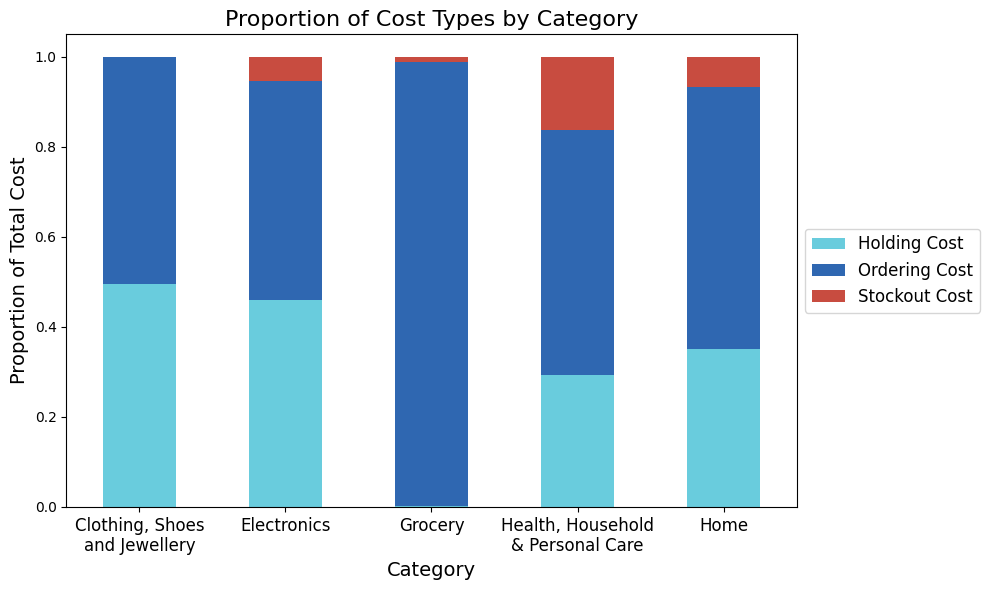

In [132]:
# Filter to get data for the top 5 categories
top_categories = ['Electronics', 'Grocery', 'Home', 'Health, Household & Personal Care', 'Clothing, Shoes and Jewellery']
filtered_df = results_df[results_df['Category'].isin(top_categories)]

# Aggregate costs by category
costs_by_category = filtered_df.groupby('Category')[['Holding Cost', 'Ordering Cost', 'Stockout Cost', 'Total Cost']].sum()

# Calculate proportions
costs_by_category['Holding Cost Proportion'] = costs_by_category['Holding Cost'] / costs_by_category['Total Cost']
costs_by_category['Ordering Cost Proportion'] = costs_by_category['Ordering Cost'] / costs_by_category['Total Cost']
costs_by_category['Stockout Cost Proportion'] = costs_by_category['Stockout Cost'] / costs_by_category['Total Cost']

colors = ['#69CCDD', '#2F67B1', '#C84C40']

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
costs_by_category[['Holding Cost Proportion', 'Ordering Cost Proportion', 'Stockout Cost Proportion']].plot(
    kind='bar', stacked=True, ax=ax, color=colors)

# Label and customize
ax.set_title('Proportion of Cost Types by Category', fontsize=16)
ax.set_xlabel('Category', fontsize=14)
ax.set_ylabel('Proportion of Total Cost', fontsize=14)

# Function to wrap text for x-axis labels based on words
def wrap_labels_by_words(labels, max_words=2):
    wrapped_labels = []
    for label in labels:
        words = label.split()
        wrapped_label = ' '.join(words[:max_words])
        if len(words) > max_words:
            wrapped_label += '\n' + ' '.join(words[max_words:])
        wrapped_labels.append(wrapped_label)
    return wrapped_labels

# Wrap x-axis labels and apply
ax.set_xticklabels(wrap_labels_by_words(costs_by_category.index), rotation=0, ha='center', fontsize=12)
ax.legend(['Holding Cost', 'Ordering Cost', 'Stockout Cost'], loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.tight_layout()

plt.show()

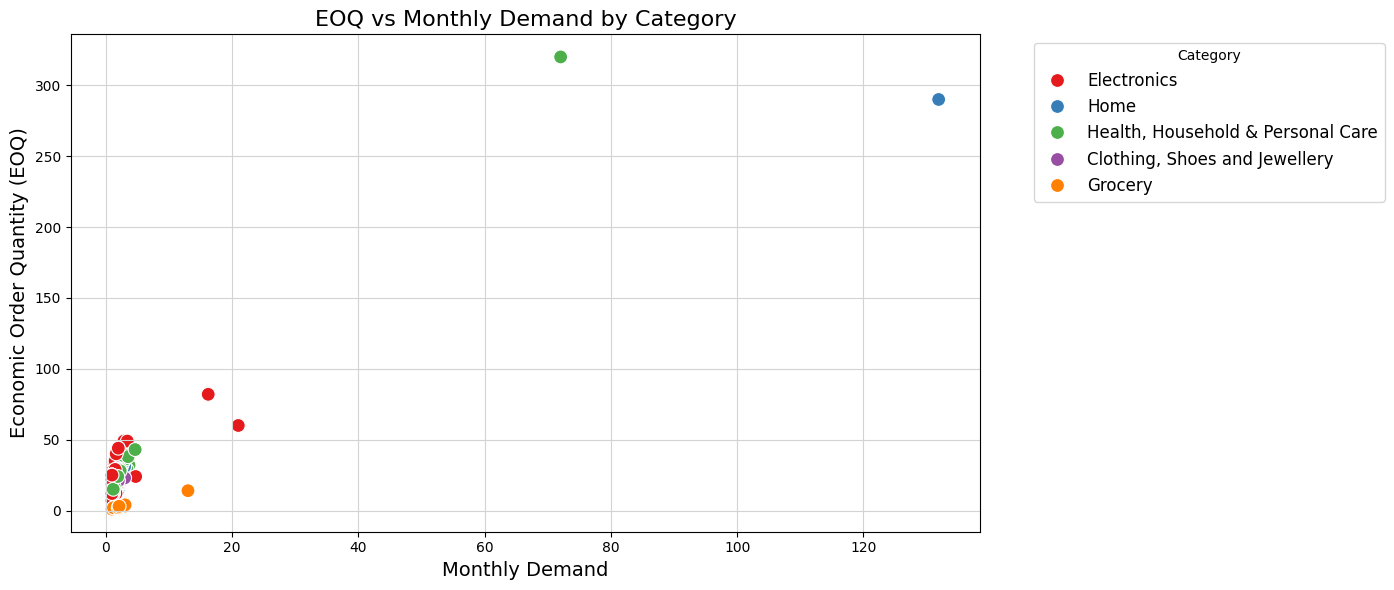

In [129]:
# Filter to get data for the top 5 categories
top_categories = ['Electronics', 'Grocery', 'Home', 'Health, Household & Personal Care', 'Clothing, Shoes and Jewellery']
filtered_df = results_df[results_df['Category'].isin(top_categories)]

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df, x='Monthly Demand', y='EOQ', hue='Category', palette='Set1', s=100, edgecolor='w')

plt.title('EOQ vs Monthly Demand by Category', fontsize=16)
plt.xlabel('Monthly Demand', fontsize=14)
plt.ylabel('Economic Order Quantity (EOQ)', fontsize=14)

plt.tight_layout()
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

plt.grid(True, color='lightgray')
plt.show()


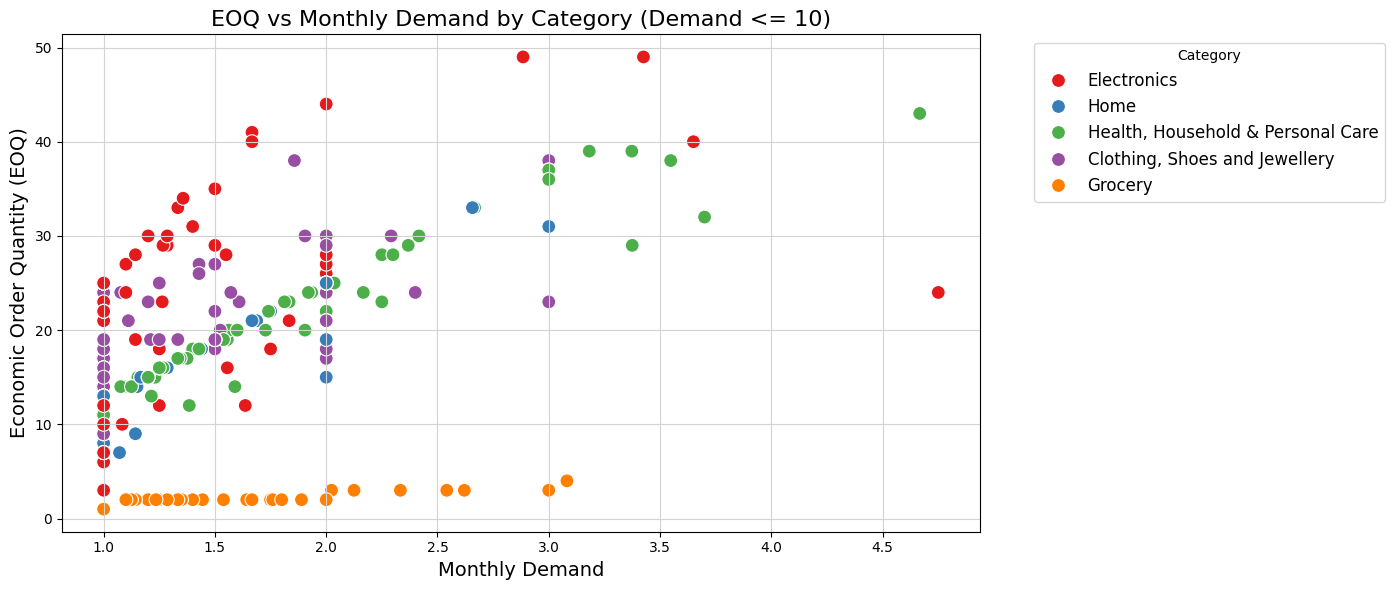

In [130]:
# Filter to get data for the top 5 categories
top_categories = ['Electronics', 'Grocery', 'Home', 'Health, Household & Personal Care', 'Clothing, Shoes and Jewellery']
filtered_df = results_df[results_df['Category'].isin(top_categories)]

# Exclude points with Monthly Demand > 10
filtered_df = filtered_df[filtered_df['Monthly Demand'] <= 10]

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df, x='Monthly Demand', y='EOQ', hue='Category', palette='Set1', s=100, edgecolor='w')
plt.title('EOQ vs Monthly Demand by Category (Demand <= 10)', fontsize=16)
plt.xlabel('Monthly Demand', fontsize=14)
plt.ylabel('Economic Order Quantity (EOQ)', fontsize=14)
plt.tight_layout()
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

plt.grid(True, color='lightgray')
plt.show()


### Creating Synthetic Inventory
To evaluate the success of the Inventory Optimisation Algorithm, we created an inventory with synthetic values without the optimisation algorithm to calculate costs prior to improvements.

In [133]:
product_info = (
    orders[orders['Title'].isin(results_df['Title'])]
    .groupby('Title')
    .agg(
        Quantity=('Quantity', 'sum'),
        Category=('Category', 'first'),
        Avg_Purchase_Price=('Purchase Price Per Unit', 'mean')
    )
    .reset_index()
)

inventory_data = results_df[['Title']].merge(product_info, on='Title', how='left')

# Designating 70% as overstocked, 30% as understocked
np.random.seed(42)
overstocked_indices = inventory_data.sample(frac=0.7, random_state=42).index
understocked_indices = inventory_data.index.difference(overstocked_indices)

# Parameters for overstock level adjustments
a, b = 5, 15 

# Adjust quantities for synthetic stock levels
inventory_data.loc[overstocked_indices, 'Synthetic Stock'] = (
    inventory_data.loc[overstocked_indices, 'Quantity'] + np.floor(np.random.normal(a, b, len(overstocked_indices)))
)
inventory_data.loc[understocked_indices, 'Synthetic Stock'] = (
    inventory_data.loc[understocked_indices, 'Quantity'] - np.floor(10 * np.random.uniform(0, 1, len(understocked_indices)))
)

inventory_data['Synthetic Stock'] = inventory_data['Synthetic Stock'].clip(lower=0)

inventory_data

,Title,Quantity,Category,Avg_Purchase_Price,Synthetic Stock
0,Yaktrax Hiking and Walking Traction Cleats for...,15,Sports and Outdoors,16.779286,9.0
1,Fintie Slim Shell Case for Samsung Galaxy Tab ...,1,Electronics,10.990000,0.0
2,"Alba Botanica Hawaiian Detox Towelettes, Anti-...",3,Beauty & Personal Care,3.746667,0.0
3,Electop 3.5mm 1/8 inch Male AUX Audio Plug Jac...,1,Electronics,5.390000,0.0
4,The Lies of Locke Lamora (Gentleman Bastards),3,Books,6.496667,0.0
...,...,...,...,...,...
993,D&D Monster Manual (Dungeons & Dragons Core Ru...,30,Books,28.212414,36.0
994,Break Your Own Geodes - Set of 12 - STEM Toy a...,1,Toys and Games,9.850000,0.0
995,Shadows of Self: A Mistborn Novel (The Mistbor...,4,Books,12.612500,1.0
996,Contigo Autospout Straw Gizmo Flip Kids Water ...,7,Kitchen & Dining,11.252000,0.0


### Calculating Total Cost for Synthetic Inventory

In [137]:
stockout_cost_per_unit = 10  # Cost per unit for stockouts

# Calculate Holding Cost
inventory_data['Holding Cost'] = (
    inventory_data['Synthetic Stock'] * inventory_data['Avg_Purchase_Price'] * holding_cost_rate
)

# Estimate Ordering Cost
# Assuming one order per month for simplicity
total_orders = 0.5 * inventory_data['Quantity']
inventory_data['Ordering Cost'] = ordering_cost * total_orders

# Calculate Stockout Cost
# Calculate unmet demand if demand exceeds synthetic stock level
inventory_data['Unmet Demand'] = inventory_data['Quantity'] - inventory_data['Synthetic Stock']
inventory_data['Stockout Cost'] = (
    inventory_data['Unmet Demand'].clip(lower=0) * stockout_cost_per_unit
)

# Calculate Total Cost
inventory_data['Total Cost'] = (
    inventory_data['Holding Cost'] + inventory_data['Ordering Cost'] + inventory_data['Stockout Cost']
)

# Synthetic data with total cost
inventory_data[['Title', 'Category', 'Synthetic Stock', 'Total Cost']]

,Title,Category,Synthetic Stock,Total Cost
0,Yaktrax Hiking and Walking Traction Cleats for...,Sports and Outdoors,9.0,465.202714
1,Fintie Slim Shell Case for Samsung Galaxy Tab ...,Electronics,0.0,35.000000
2,"Alba Botanica Hawaiian Detox Towelettes, Anti-...",Beauty & Personal Care,0.0,105.000000
3,Electop 3.5mm 1/8 inch Male AUX Audio Plug Jac...,Electronics,0.0,35.000000
4,The Lies of Locke Lamora (Gentleman Bastards),Books,0.0,105.000000
...,...,...,...,...
993,D&D Monster Manual (Dungeons & Dragons Core Ru...,Books,36.0,953.129379
994,Break Your Own Geodes - Set of 12 - STEM Toy a...,Toys and Games,0.0,35.000000
995,Shadows of Self: A Mistborn Novel (The Mistbor...,Books,1.0,132.522500
996,Contigo Autospout Straw Gizmo Flip Kids Water ...,Kitchen & Dining,0.0,245.000000


In [138]:
total_cost_inventory_data = inventory_data['Total Cost'].sum()
total_cost_results_df = results_df['Total Cost'].sum()

# Calculate the percentage difference
percentage_difference = ((total_cost_inventory_data - total_cost_results_df) / total_cost_inventory_data) * 100

print(f"Percentage Difference in Total Cost: {percentage_difference:.2f}%")

Percentage Difference in Total Cost: 59.93%
